**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [6]:
import warnings

warnings.filterwarnings('ignore')

In [7]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
start = time()
path = './min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance,WTICO_USD:binance,XAU_USD:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)


In [8]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv30M = HFDataView()
dv1H = HFDataView()

In [9]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [10]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

In [11]:
Gap30M = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

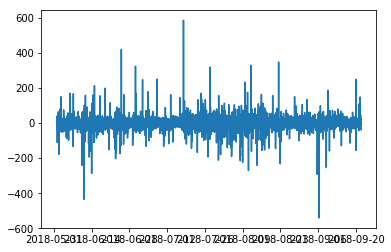

In [12]:
#观察价差
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])

plt.show()

In [13]:
#30min的图

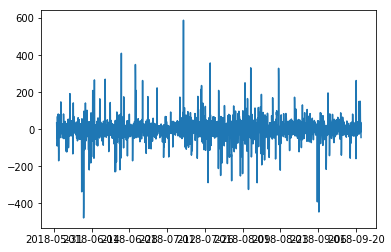

In [14]:

plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

In [15]:
#1H的图

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [16]:
# 进场信号
long = dv1H.add_formula("long","If((Ts_Mean(close,20)>Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)<=Delay(Ts_Mean(close,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(close,20)<Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)>=Delay(Ts_Mean(close,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [17]:
for dvAdd in [dv30M,dv1H]:
    dvAdd.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0,StdDev(Return(close,1),20),close),2),5)',add_data = True)

In [18]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [19]:
TimingSignal(tdMa, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [20]:
for dvAdd in [dv30M,dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [21]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [22]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha1_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

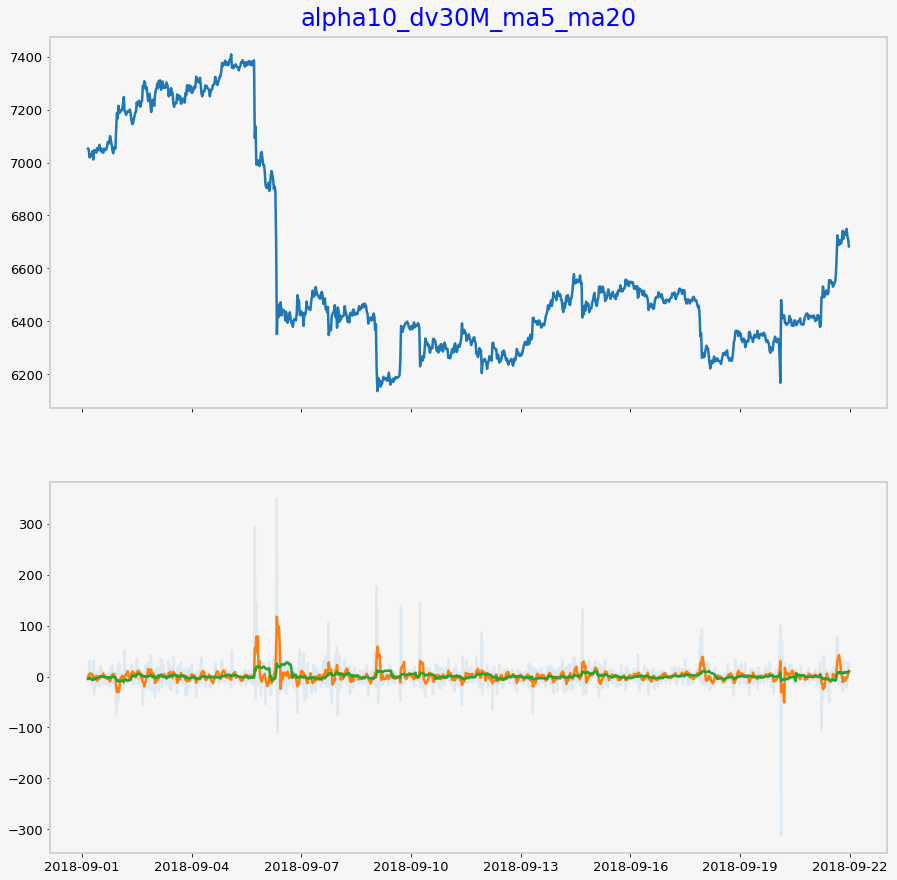

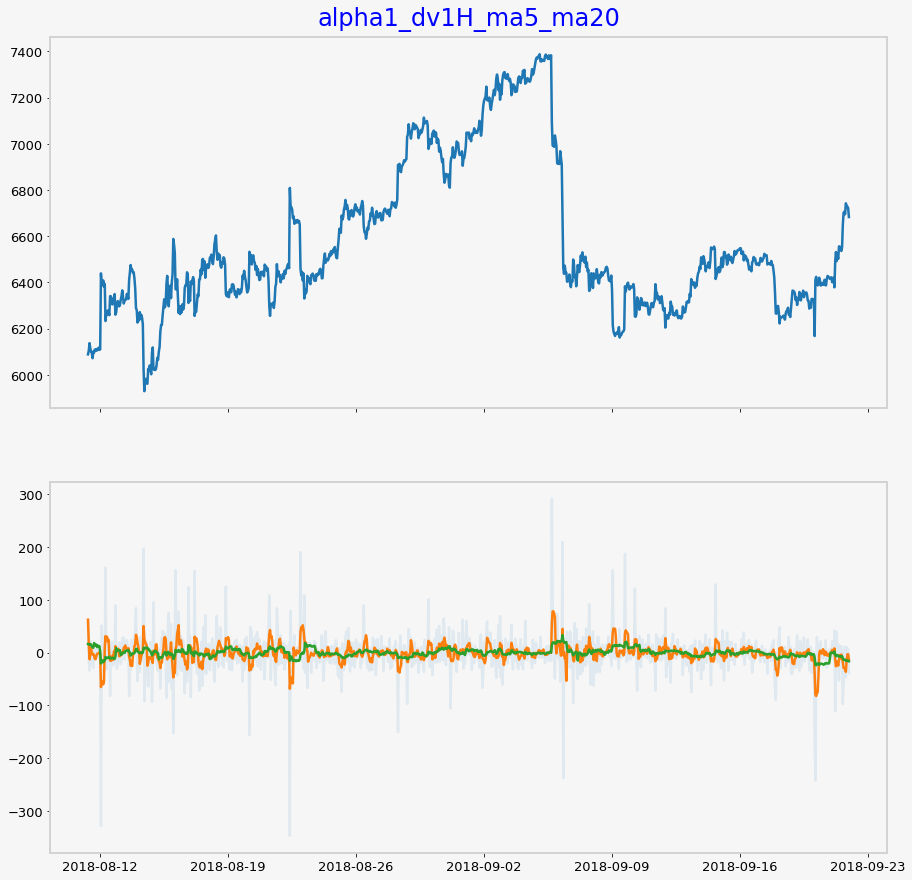

In [23]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [24]:
long = dv1H.add_formula("long","If((Ts_Mean(close,20)>Ts_Mean(close,55))&&(Delay(Ts_Mean(close,20),1)<=Delay(Ts_Mean(close,55),1)),2,0)",add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(close,20)<Ts_Mean(close,55))&&(Delay(Ts_Mean(close,20),1)>=Delay(Ts_Mean(close,55),1)),-2,0)",add_data=True)

close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)",add_data = True)
close_short = dv1H.add_formula("closeShort","If(short==-2,-1,0)",add_data = True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [25]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

In [26]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [27]:
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha001')

TimingSignal(tdAlpha1, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [28]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [29]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
start = time()
path = './min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance,WTICO_USD:binance,XAU_USD:binance',
         'freq': '1H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.8460001945495605


In [30]:
data1H = Time_dict.set_index('datetime')

In [31]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [32]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [33]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [34]:
def location(df):
    Location = (df.close-df.low.rolling(50).min())/(df.high.rolling(50).max()-df.low.rolling(50).min())*100
    return Location

Location = location(data1H)

In [35]:
import talib as ta
Morningstar = dv1H.add_formula('Morningstar',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

In [36]:
dataMorningstar= dv1H.get_ts('Morningstar', date_type='datetime')

In [37]:
dataMorningstar[dataMorningstar['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [38]:
scatterBigUpX = dataMorningstar[dataMorningstar['BTCUSDT:binance']==100].index

In [39]:
scatterBigUpY = data1H.loc[scatterBigUpX].low-100

In [40]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

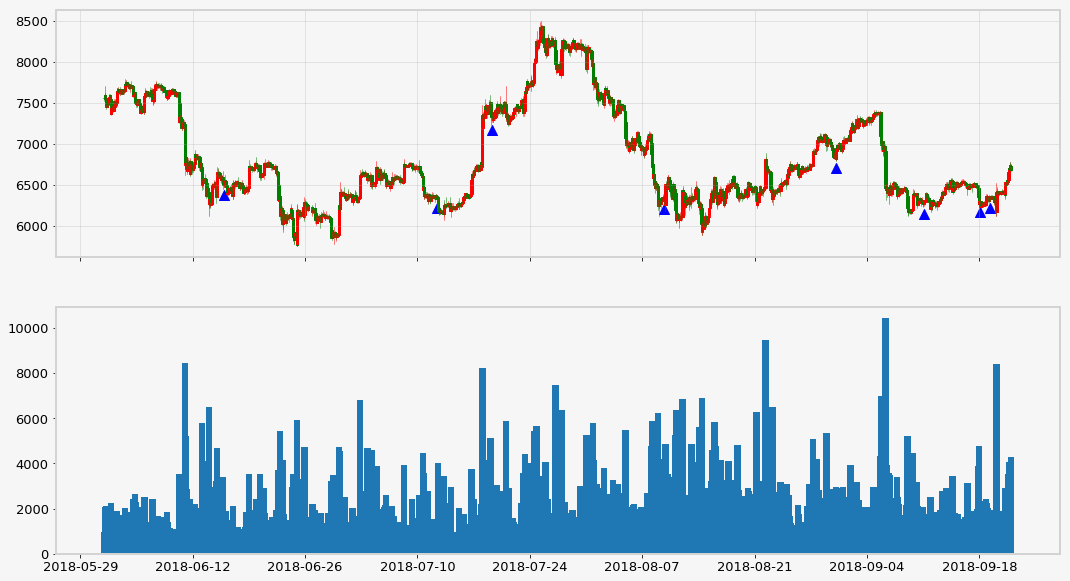

In [41]:
draw_candle(candle, scatterBigUpX, scatterBigUpY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [16]:
import warnings

warnings.filterwarnings('ignore')

In [17]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'close,low,high','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.618000030517578


In [18]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [19]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [20]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha.iloc[-1000:])
    # plt.savefig('good')
    plt.show()

In [21]:
EMA10_J = dv.add_formula('EMA10_J', "Ta('EMA',0,0,0,0,close,0,10)",
                             add_data=True)

In [22]:
ema_plot = dv.get_ts('EMA10_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')


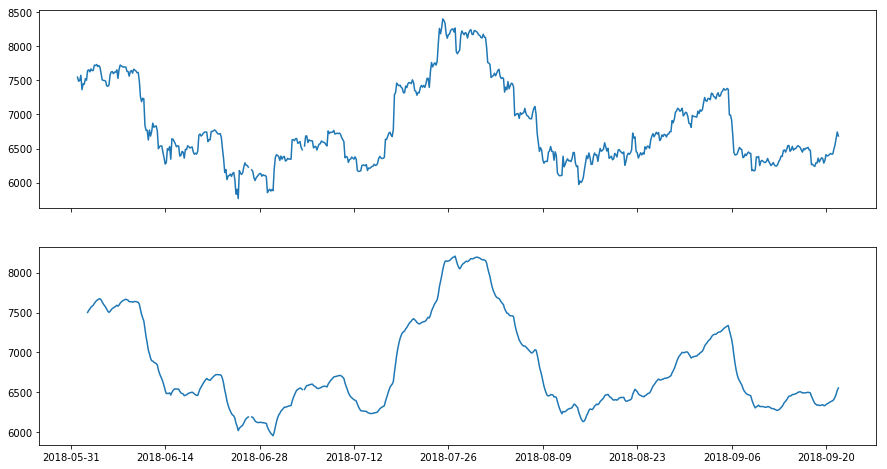

In [23]:
plot_chart(close, ema_plot)

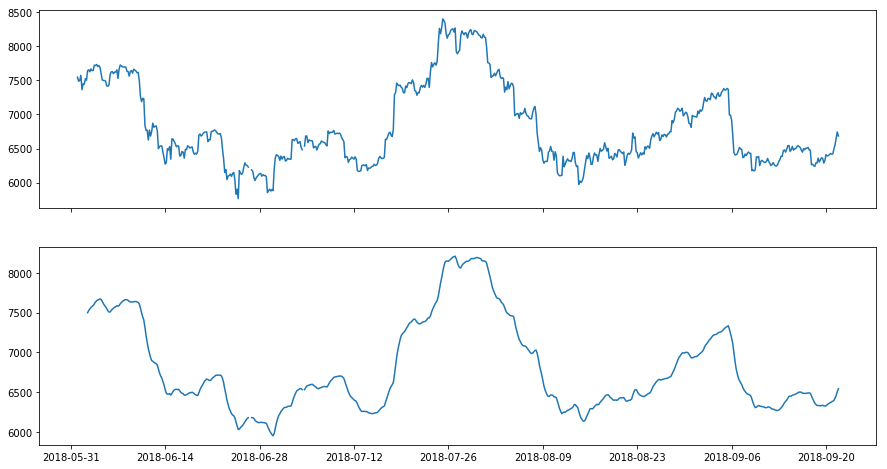

In [24]:
YB = dv.add_formula('YB',"Ta('EMA',0,0,0,0,(close + high + low)/3,10)",add_data = True)
YB_plot = dv.get_ts('YB', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, YB_plot)

In [25]:

ER_Ratio = dv.add_formula('ER_Ratio','(Delta(close,1) - Delta(close,21)) / Ts_Sum(Abs(Delta(close,1) - Delta(close,2)),21)',add_data = True)
ER_plot = dv.get_ts('ER_Ratio', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')


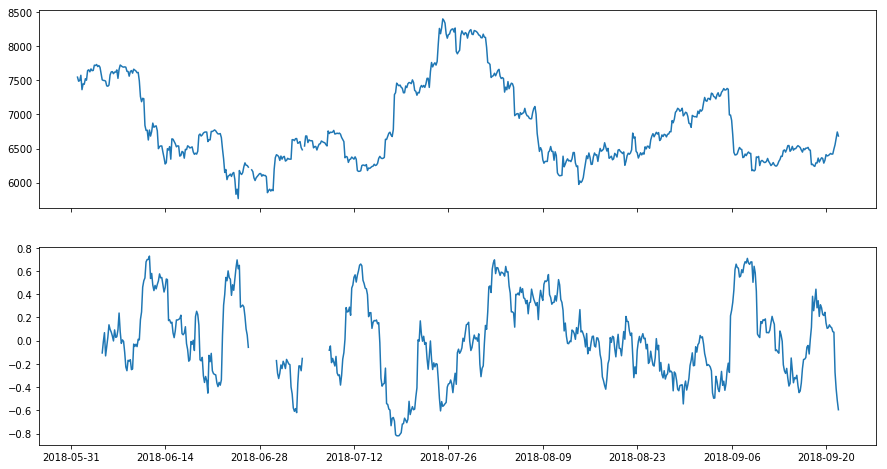

In [26]:
plot_chart(close, ER_plot)

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [ ]:
macd CCI 与价格图的联系：
MACD（根据长短两条不同周期的平均线之间的离差值研究行情）：当DIF向上交叉DEA线时，此时为买点；DIF向下交叉DEA时，死叉产生卖点。
CCI：顺势指标 主要用来应对极端行情
进场信号：当macd金叉、同时CCI> 100，确立进场信号，开多
          当macd死叉、同时CCI< -100,确立进场信号，开空
出场信号:
          macd死叉，确立出场信号，平多
          macd金叉，确立出场信号，平空
          

Initialize dataview success.


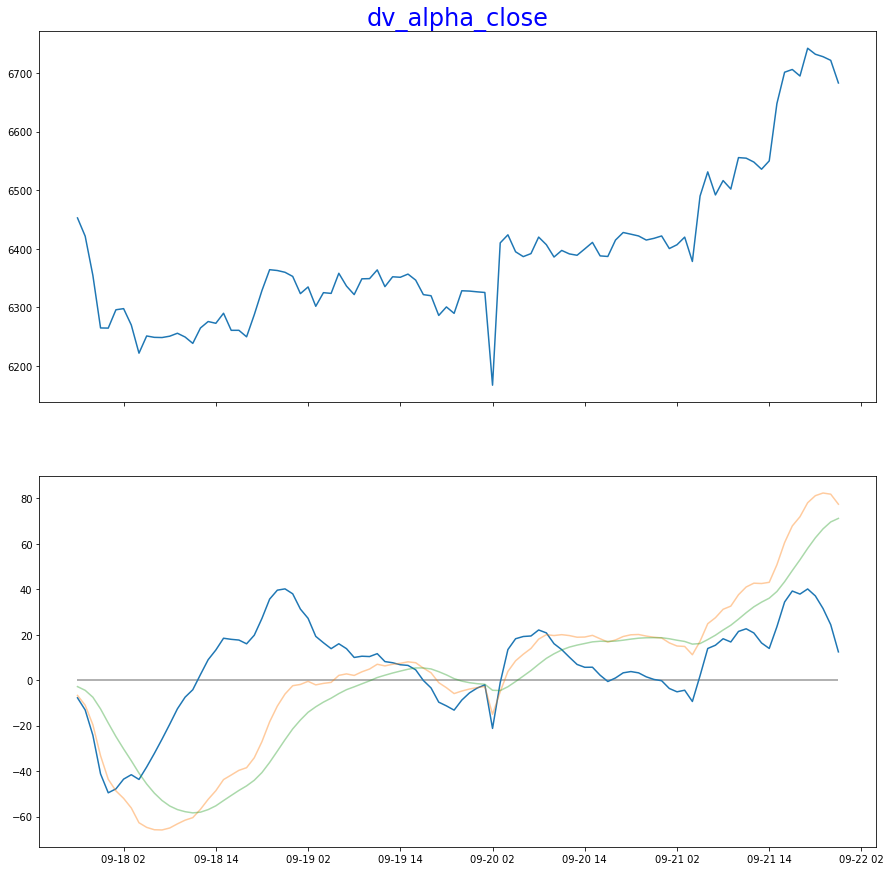

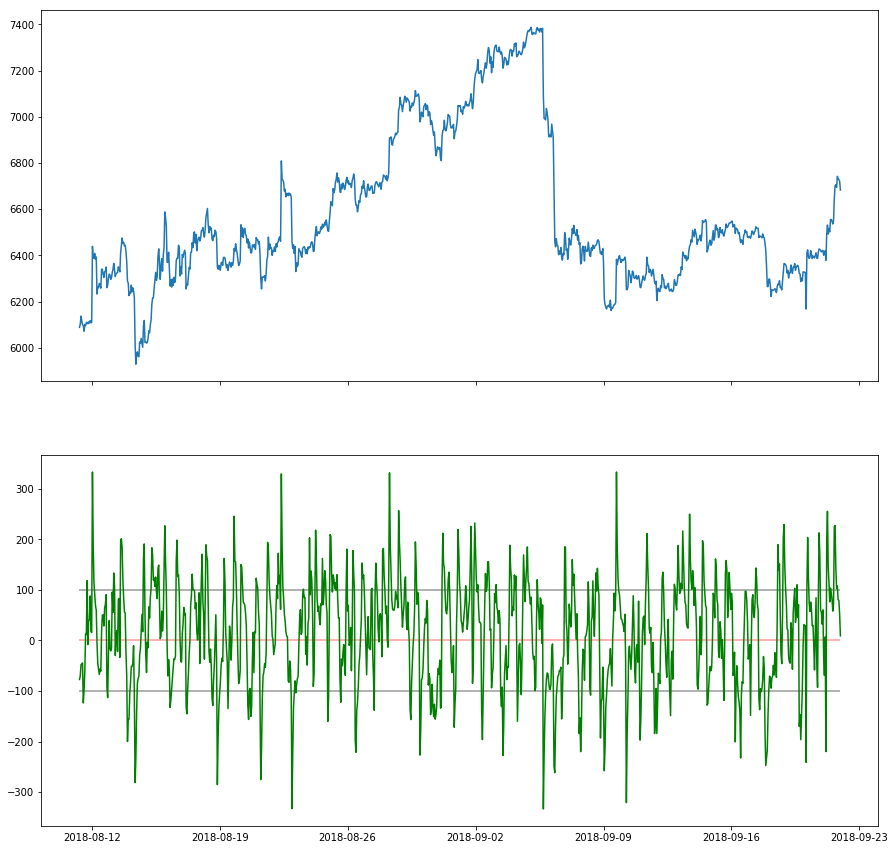

In [1]:
# 因子一：MACD

import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, Diff, Dea, chart_name='dv_MACD', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=1)
    ax1.plot(Diff.iloc[n:], alpha=0.4)
    ax1.plot(Dea.iloc[n:], alpha=0.4)
    ax1.hlines(0, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.4)
#     ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
#     ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    # plt.savefig(chart_name)
    plt.show()
def Plot_Mean1(dv, alpha1, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:,0])
    ax1.plot(alpha1.iloc[n:], 'g',alpha=1)
    ax1.hlines(0, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], 'r',alpha = 0.4)
    ax1.hlines(100, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], alpha=0.4)
    ax1.hlines(-100, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], alpha=0.4)
#     ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
#     ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    # plt.savefig(chart_name)
    plt.show()
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('Diff_J', "Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)", add_data=True)
dv1H.add_formula('Dea_J',"Ta('EMA',0,0,0,0,Diff_J,0,9)", add_data=True)
dv1H.add_formula('MACD_J',"(Diff_J-Dea_J)*2",add_data=True)
dv1H.add_formula("CCI10_J","Ta('CCI',0,0,high,low,close,0,10)" ,add_data=True)
CCI = dv1H.get_ts('CCI10_J', date_type='datetime')
MACD = dv1H.get_ts('MACD_J', date_type='datetime')
Diff = dv1H.get_ts('Diff_J', date_type='datetime')
Dea = dv1H.get_ts('Dea_J', date_type='datetime')
# 橘色短线 绿色长线
Plot_Mean(dv1H,MACD.iloc[:,0], Diff.iloc[:,0], Dea.iloc[:,0], chart_name='dv_alpha_close', ShortPeriod=5, LongPeriod=20, n=-100)
Plot_Mean1(dv1H,CCI.iloc[:,0], n=-1000)

In [2]:
# 5、设定进出场条件
long = dv1H.add_formula('long',"If(CCI10_J>100 && Diff_J>Dea_J && Delay(Diff_J,1)<Delay(Dea_J,1),2,0)", add_data=True)
short = dv1H.add_formula('short',"If(CCI10_J<-100 && Diff_J<Dea_J && Delay(Diff_J,1)>Delay(Dea_J,1),-2,0)", add_data=True)
closeLong = dv1H.add_formula('closeLong','If(Diff_J<Dea_J && Delay(Diff_J,1)>Delay(Dea_J,1),1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(Diff_J>Dea_J && Delay(Diff_J,1)<Delay(Dea_J,1),-1,0)', add_data=True)
#closeLong = dv1H.add_formula('closeLong','If(MA_5 > MA_20&&(Delay(MA_5,1)<Delay(MA_20,1)),1,0)', add_data=True)
#closeShort = dv1H.add_formula("closeShort",'If(MA_5 < MA_20&&(Delay(MA_5,1)>Delay(MA_20,1)),1,0)', add_data=True)

In [3]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv1H, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 51%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 46%


In [4]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win      loss       all
t-stat               15.065   -42.406    -1.563
p-value               0.000     0.000     0.118
mean                  0.044    -0.017    -0.002
std                   0.055     0.013     0.040
info_ratio            0.803    -1.328    -0.042
skewness              1.348    -1.114     2.698
kurtosis              0.538     1.415     8.340
pct5                  0.000    -0.042    -0.039
pct25                 0.004    -0.026    -0.020
pct50                 0.020    -0.014    -0.010
pct75                 0.070    -0.008     0.000
pct95                 0.171    -0.002     0.084
occurance           353.000  1021.000  1374.000
win_ratio               NaN       NaN     0.257
win_mean/loss_mean      NaN       NaN     2.514


In [5]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               21.132  -30.598     0.915
p-value               0.000    0.000     0.361
mean                  0.036   -0.022     0.001
std                   0.037    0.019     0.040
info_ratio            0.953   -1.120     0.026
skewness              1.239   -1.306     1.142
kurtosis              1.170    1.398     2.310
pct5                  0.001   -0.062    -0.050
pct25                 0.006   -0.032    -0.020
pct50                 0.020   -0.016    -0.004
pct75                 0.067   -0.007     0.011
pct95                 0.100   -0.001     0.084
occurance           493.000  747.000  1240.000
win_ratio               NaN      NaN     0.398
win_mean/loss_mean      NaN      NaN     1.634


In [6]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win      loss       all
t-stat               24.925   -49.849    -0.512
p-value               0.000     0.000     0.608
mean                  0.039    -0.019    -0.000
std                   0.046     0.016     0.040
info_ratio            0.857    -1.186    -0.010
skewness              1.467    -1.441     1.968
kurtosis              1.486     2.458     5.423
pct5                  0.001    -0.048    -0.045
pct25                 0.005    -0.028    -0.020
pct50                 0.020    -0.015    -0.008
pct75                 0.068    -0.007     0.004
pct95                 0.160    -0.001     0.084
occurance           846.000  1768.000  2614.000
win_ratio               NaN       NaN     0.324
win_mean/loss_mean      NaN       NaN     2.026


# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [ ]:
macd CCI 与价格图的联系：
MACD（根据长短两条不同周期的平均线之间的离差值研究行情）：当DIF向上交叉DEA线时，此时为买点；DIF向下交叉DEA时，死叉产生卖点。
CCI：顺势指标 主要用来应对极端行情
进场信号：当macd金叉、同时CCI> 100，确立进场信号，开多
          当macd死叉、同时CCI< -100,确立进场信号，开空
出场信号:
          5日均线下穿10日均线，确立出场信号，平多
          5日均线上穿10日均线，确立出场信号，平空
          

In [19]:
# 因子一：MACD

import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, Diff, Dea, chart_name='dv_MACD', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=1)
    ax1.plot(Diff.iloc[n:], alpha=0.4)
    ax1.plot(Dea.iloc[n:], alpha=0.4)
    ax1.hlines(0, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.4)
#     ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
#     ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    # plt.savefig(chart_name)
    plt.show()
def Plot_Mean1(dv, alpha1, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:,0])
    ax1.plot(alpha1.iloc[n:], 'g',alpha=1)
    ax1.hlines(0, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], 'r',alpha = 0.4)
    ax1.hlines(100, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], alpha=0.4)
    ax1.hlines(-100, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], alpha=0.4)
#     ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
#     ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    # plt.savefig(chart_name)
    plt.show()
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))
dv1H.add_formula("CCI_J","Ta('CCI',0,0,high,low,close,0,10)" ,add_data=True)
dv1H.add_formula('MA_5',"Ta('MA',0,0,0,0,close,0,5)", add_data=True)
dv1H.add_formula('MA_20',"Ta('MA',0,0,0,0,close,0,10)", add_data=True)
CCI = dv1H.get_ts('CCI_J', date_type='datetime')

#ER_Ratio = dv1H.add_formula('ER_Ratio','(Delta(close,1) - Delta(close,21)) / Ts_Sum(Abs(Delta(close,1) - Delta(close,2)),21)',add_data = True)
#ER_plot = dv.get_ts('ER_Ratio', date_type='datetime')
#close = dv.get_ts('close', date_type='datetime')

# 5、设定进出场条件
long = dv1H.add_formula('long',"If(CCI_J > 100,2,0)", add_data=True)
short = dv1H.add_formula('short',"If(CCI_J < -100,-2,0)", add_data=True)
closeLong = dv1H.add_formula('closeLong','If(MA_5 > MA_20&&(Delay(MA_5,1)<Delay(MA_20,1)),1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(MA_5 < MA_20&&(Delay(MA_5,1)>Delay(MA_20,1)),1,0)', add_data=True)

Initialize dataview success.


In [20]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv1H, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 15%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 16%


In [21]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               12.271   -9.924   -0.548
p-value               0.000    0.000    0.584
mean                  0.014   -0.014   -0.001
std                   0.016    0.021    0.024
info_ratio            0.883   -0.678   -0.027
skewness              2.217   -3.016   -1.011
kurtosis              6.549   10.018    7.082
pct5                  0.001   -0.049   -0.036
pct25                 0.003   -0.015   -0.007
pct50                 0.009   -0.007   -0.001
pct75                 0.021   -0.003    0.009
pct95                 0.047   -0.001    0.032
occurance           194.000  215.000  409.000
win_ratio               NaN      NaN    0.474
win_mean/loss_mean      NaN      NaN    1.013


In [22]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               22.822  -18.375    2.312
p-value               0.000    0.000    0.021
mean                  0.062   -0.046    0.007
std                   0.040    0.037    0.066
info_ratio            1.560   -1.245    0.111
skewness              0.207   -1.659   -0.060
kurtosis             -0.774    2.390   -0.264
pct5                  0.003   -0.144   -0.095
pct25                 0.025   -0.054   -0.037
pct50                 0.066   -0.036   -0.001
pct75                 0.094   -0.024    0.066
pct95                 0.118   -0.006    0.113
occurance           215.000  219.000  434.000
win_ratio               NaN      NaN    0.495
win_mean/loss_mean      NaN      NaN    1.341


In [23]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               20.454  -18.498    1.996
p-value               0.000    0.000    0.046
mean                  0.039   -0.030    0.003
std                   0.039    0.034    0.050
info_ratio            1.013   -0.889    0.069
skewness              0.955   -1.976    0.057
kurtosis             -0.092    4.079    1.442
pct5                  0.001   -0.111   -0.069
pct25                 0.007   -0.040   -0.022
pct50                 0.023   -0.021   -0.001
pct75                 0.068   -0.005    0.022
pct95                 0.113   -0.001    0.103
occurance           409.000  434.000  843.000
win_ratio               NaN      NaN    0.485
win_mean/loss_mean      NaN      NaN    1.297
